In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import time
from sklearn.model_selection import train_test_split
from statistics import mean
from u_net import UNet
import torch
from skimage import measure

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [107]:
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        mean = np.mean(files)
        std = np.std(files)
        standardized_files = [(image-mean)/std for image in files]
        return standardized_files
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

def split_image(img):
    
    # Split the input array into smaller arrays of size 256x256
    sub_images = []
    for i in range(0, img.shape[0], 256):
        for j in range(0, img.shape[1], 256):
            sub_img = img[i:i+256, j:j+256]
            sub_images.append(sub_img)
            
    return sub_images

def split_image(img):
    
    # Split the input array into smaller arrays of size 256x256
    sub_images = []
    for i in range(0, img.shape[0], 256):
        for j in range(0, img.shape[1], 256):
            sub_img = img[i:i+256, j:j+256]
            sub_images.append(sub_img)
            
    return sub_images

def combine_images(sub_images):
    
    # Create a NumPy array of size 1024x1024 to store the combined image
    img = np.zeros((1024, 1024))
    
    # Combine the smaller arrays into the larger image
    k = 0
    for i in range(0, img.shape[0], 256):
        for j in range(0, img.shape[1], 256):
            img[i:i+256, j:j+256] = sub_images[k]
            k += 1
            
    return img

def get_prediction(image, model):
    splitted = split_image(image)
    predictions = []
    for split in splitted:
        split = torch.from_numpy(split)
        split = split.unsqueeze(0)
        split = split.unsqueeze(0)
        split = split.to('cuda:0')
        prediction = model(split)
        prediction = prediction.squeeze(0)
        prediction = prediction.squeeze(0)
        #prediction = torch.sigmoid(prediction)
        predictions.append(prediction.cpu().detach().numpy())
    combined_prediction = combine_images(predictions)
    combined_prediction = torch.from_numpy(combined_prediction)
    combined_prediction = torch.sigmoid(combined_prediction)
    prediction = np.where(combined_prediction > 0.4, 1, 0)
    prediction = split_image(prediction)
    #predictions.append(combined_prediction.cpu().detach().numpy())
    #combined_prediction = combine_images(predictions)
    return prediction

images, masks = get_data("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DH-GOWT1/', set='0102', normalise_images=True)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [108]:
model_distilled = UNet()
model_distilled.to("cuda:0")
model_distilled.load_state_dict(torch.load("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\distillation_model_GOWT1_5"))

model_distilled_predictions = []
for i in range(len(X_test)):
    model_distilled_predictions.append(get_prediction(X_test[i], model_distilled))

model_distilled_predictions = np.array(model_distilled_predictions)
model_distilled_predictions = model_distilled_predictions.reshape((model_distilled_predictions.shape[0]*model_distilled_predictions.shape[1], model_distilled_predictions.shape[2], model_distilled_predictions.shape[3]))

In [109]:
model_normal = UNet()
model_normal.to("cuda:0")
model_normal.load_state_dict(torch.load("c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\unet_no_distillation_GOWT1"))

model_normal_predictions = []
for i in range(len(X_test)):
    model_normal_predictions.append(get_prediction(X_test[i], model_normal))

model_normal_predictions = np.array(model_normal_predictions)
model_normal_predictions = model_normal_predictions.reshape((model_normal_predictions.shape[0]*model_normal_predictions.shape[1], model_normal_predictions.shape[2], model_normal_predictions.shape[3]))

In [110]:
cellpose_trained = models.CellposeModel(gpu=core.use_gpu(), device=torch.device("cuda:0"), pretrained_model="c:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\segmentation\\train_dir\\models\\cellpose_trained_model_GOWT1_3")
cellpose_trained_predictions = []
for i in range(len(X_test)):
    prediction = cellpose_trained.eval(X_test[i], channels=[0,0])
    split_prediction = split_image(prediction[0])
    cellpose_trained_predictions.append(split_prediction)

cellpose_trained_predictions = np.array(cellpose_trained_predictions)
cellpose_trained_predictions = cellpose_trained_predictions.reshape((cellpose_trained_predictions.shape[0]*cellpose_trained_predictions.shape[1], cellpose_trained_predictions.shape[2], cellpose_trained_predictions.shape[3]))

In [111]:
cellpose = models.Cellpose(gpu=core.use_gpu(), device=torch.device("cuda:0"))
cellpose_predictions = []
for i in range(len(X_test)):
    prediction = cellpose.eval(X_test[i], channels=[0,0])
    split_prediction = split_image(prediction[0])
    cellpose_predictions.append(split_prediction)

cellpose_predictions = np.array(cellpose_predictions)
cellpose_predictions = cellpose_predictions.reshape((cellpose_predictions.shape[0]*cellpose_predictions.shape[1], cellpose_predictions.shape[2], cellpose_predictions.shape[3]))


In [112]:
print(len(cellpose_predictions))
print(len(cellpose_trained_predictions))

592
592


In [113]:
X_test_splitted = []
for i in range(len(X_test)):
    X_test_splitted.append(split_image(X_test[i]))
X_test_splitted = np.array(X_test_splitted)
X_test_splitted = X_test_splitted.reshape((X_test_splitted.shape[0]*X_test_splitted.shape[1], X_test_splitted.shape[2], X_test_splitted.shape[3]))

y_test_splitted = []
for i in range(len(y_test)):
    y_test_splitted.append(split_image(y_test[i]))
y_test_splitted = np.array(y_test_splitted)
y_test_splitted = y_test_splitted.reshape((y_test_splitted.shape[0]*y_test_splitted.shape[1], y_test_splitted.shape[2], y_test_splitted.shape[3]))

In [114]:
#get percentage of pixels equal to 1 per image in X_test_splitted
X_test_splitted_percentage = []
for i in range(len(X_test_splitted)):
    X_test_splitted_percentage.append(np.sum(X_test_splitted[i])/65536)
print(mean(X_test_splitted_percentage))

0.0007423331138910286


In [122]:
y_test_splitted_sorted_indices = []
for i in range(len(y_test_splitted)):
    #if percentage of pixels equal to 1 in y_test_splitted is greater than 0.1, add the corresponding y_test_splitted to y_test_splitted_sorted
    if np.sum(y_test_splitted[i])/65536 > 0.5:
        y_test_splitted_sorted_indices.append(i)

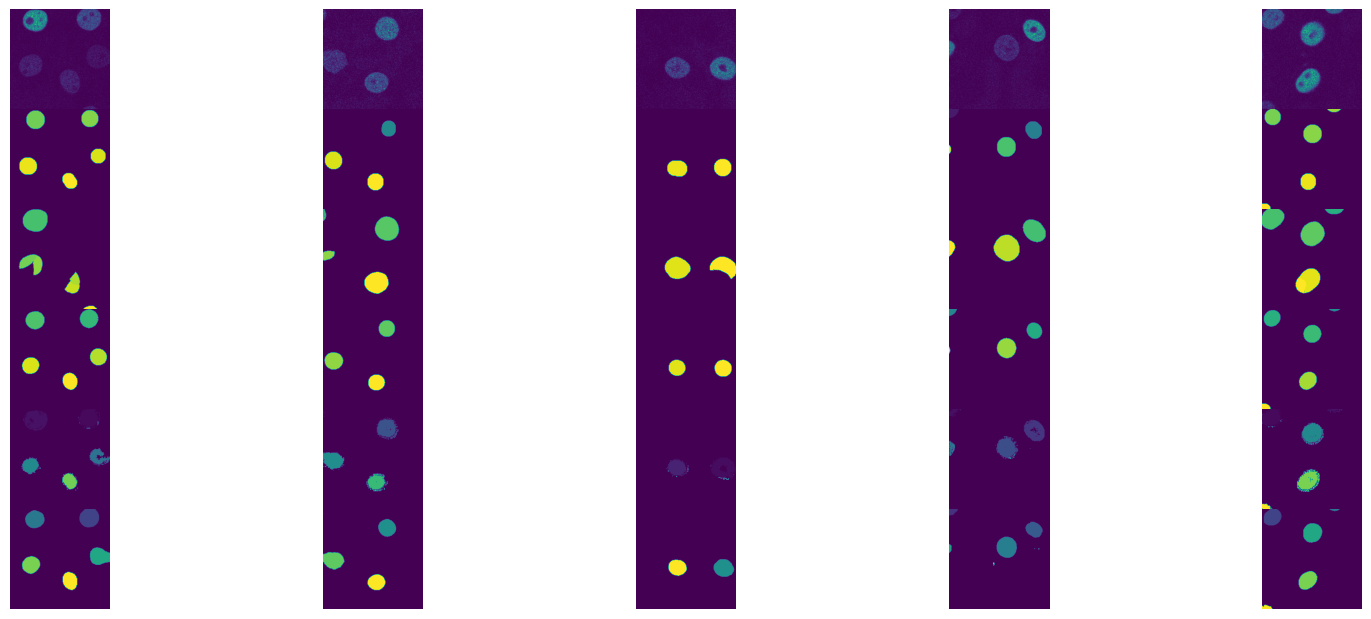

In [131]:
#make crops of 256x256 of the test images with random coordinates, then plot the test image crop, the mask crop, the cellpose prediction crop and the distilled prediction crop
import random
import matplotlib.pyplot as plt
import numpy as np

#make the first row the test images, second row the masks, third row the cellpose predictions and fourth row the distilled predictions
images = np.array(images)
masks = np.array(masks)
#cellpose_predictions = np.array(cellpose_predictions)
#distilled_predictions = np.array(distilled_predictions)

#plot the images
fig, ax = plt.subplots(6,5, figsize=(20,10))
for i in range(5):
    #chhose a random image index from y_test_splitted_sorted_indices
    image_index = random.choice(y_test_splitted_sorted_indices)
    ax[0,i].imshow(X_test_splitted[image_index])
    ax[1,i].imshow(y_test_splitted[image_index])
    ax[2,i].imshow(cellpose_predictions[image_index])
    ax[3,i].imshow(cellpose_trained_predictions[image_index])

    model_norm = measure.label(model_normal_predictions[image_index] > 0, connectivity=2) 
    ax[4,i].imshow(model_norm)

    model_norm = measure.label(model_distilled_predictions[image_index] > 0, connectivity=2) 
    ax[5,i].imshow(model_norm)

    #ax[0,i].set_title('Test image')
    #ax[1,i].set_title('Mask')
    #ax[2,i].set_title('Cellpose prediction')
    #ax[3,i].set_title('Distilled prediction')
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
    ax[3,i].axis('off')
    ax[4,i].axis('off')
    ax[5,i].axis('off')
plt.subplots_adjust(top = 0.6, bottom=0, hspace=0, wspace=0.05)
plt.show()

